In this notebook, I demonstrate how to fit static site-occupancy models in PyMC [@royle2008, Chapter 3]. The standard site-occupancy model models binary detection/non-detection data $y_{j,k}$ for repeated surveys $k=1,2,\dots,K$ at sites $j=1,2,\dots,J.$ The species is present at the sites when $z_j=1,$ and absent otherwise. We assume that our probability of detecting the species given that the site is occupied is  $P(y_{j,k}|z_j=1)=p,$ and zero when the site is unoccupied. The probability of occurrence, which is typically the parameter of interest, is $P(z_{j}=1)=\psi.$ As such, we can think of this as a zero-inflated binomial model, where
$$ 
\begin{align}
&y_j \sim 
\begin{cases}
    0,   & \text{if } z_j = 0 \\
    \text{Binomial}(K, p),   & \text{if } z_j = 1
\end{cases} \\
&z_j \sim \text{Bernoulli}(\psi) 
\end{align},
$$
which assumes a constant occurrence probability across sites and a constant detection probability. I start with this simple model, then add site- and visit-level covariates later. 

# Simulated examples

To start, I demonstrate how to simulate this zero-inflated model using numpy. 

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd

def scale(x):
    return (x - np.nanmean(x)) / np.nanstd(x)

def invlogit(x):
    return 1 / (1 + np.exp(-x))

def sim_y(p, z, site_count, visit_count):
    
    ones = np.ones((site_count, visit_count))
    p_array = p * ones 

    flips = rng.binomial(1, p_array)
    y = (flips.T * z_true).T
    
    return y 

## simulation

SEED = 808
rng = np.random.default_rng(seed=SEED)

# sampling characteristics
site_count = 200
visit_count = 3

## ecological model

# true parameter values
psi_true = 0.8

# simulate occurrence state
z_true = rng.binomial(1, psi_true, size=site_count)

## detection model

# true parameter values
p_true = 0.5

# simulate detection
y = sim_y(p_true, z_true, site_count, visit_count)

# number of detections at each site 
y_summarized = y.sum(axis=1)

# detection data at the first five sites 
y[:5]

array([[0, 1, 1],
       [1, 0, 1],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 1]])

## Estimating parameters with PyMC

Next, I use PyMC to train the occupancy model with the simulated data. First, similar to JAGS and Stan, the model must be specified using the PyMC syntax. This is done using a [context manager](https://peps.python.org/pep-0343/) in Python, essentially, a `with` statement. This creates a `Model` object. 

In [2]:
with pm.Model() as constant:

    # priors for the detetion and occurrence probabilities\
    psi = pm.Uniform('psi', 0, 1)
    p = pm.Uniform('p', 0, 1)

    # likelihood for the summarized data
    pm.ZeroInflatedBinomial('y', p=p, psi=psi, n=visit_count, 
                            observed=y_summarized)

In JAGS, the prior for $p$ would be specified as `p ~ dunif(0, 1).` The PyMC equivalent is `p = pm.Uniform('p', 0, 1)`. This could, alternatively, be specified as `p = pm.Uniform('detection probability', 0, 1)`. For the likelihood, I use PyMC's built-in `ZeroInflatedBinomial` distribution. We tell PyMC that this is an observed random variable by supplying data to the `observed` argument. PyMC also has handy tools for visualizing the model.

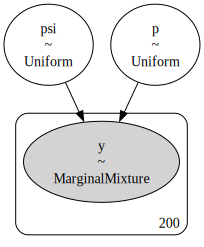

In [3]:
#| fig-cap: 'The simplest possible occupancy model. Random variables appear as unshaded ellipses while data appears shaded. Notice the ''200'', which states that there are 200 observations (sites) of this random variable.'
pm.model_to_graphviz(constant)

Now I can sample from the posterior. Again, I use the context manager, this time referring to the model by name. It's typical to name the output with `idata` because, by default, PyMC returns an object of class `InferenceData` from the Arviz package. Arviz is similar to the coda package for R.

In [4]:
#| output: asis
with constant:
    constant_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


PyMC will try to use the No-U-Turn Sampler (NUTS) whenever possible. As you can see, it samples the posterior quickly. I can plot the output using the `az.plot_trace()`, supplying the true values for $p$ and $\psi$ for comparizon. I can also look at a tabular summary using `az.summary()`.

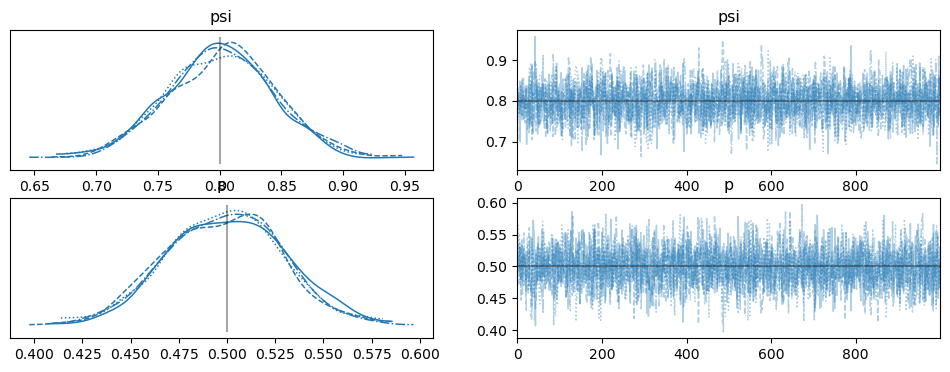

In [5]:
#| fig-cap: Estimated parameter values with the true values represented by vertical and horizontal lines.
az.plot_trace(
    constant_idata,
    lines=[("psi", {}, [psi_true]), ("p", {}, [p_true])] 
);

In [6]:
az.summary(constant_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
psi,0.801,0.043,0.718,0.879,0.001,0.001,2273.0,1970.0,1.0
p,0.499,0.030,0.441,0.553,0.001,0.000,2067.0,2291.0,1.0


## Adding site covariates

Next, I add in some realism by simulating a site-level covariate $x$ that affects the occurrence probability. I model this effect with a logit-linear model, i.e., $\psi_j=\text{logit}^{-1}(\beta_0 + \beta_1 x_j).$ 

In [7]:
## ecological model

# true parameter values
beta0_true = -1
beta1_true = 3

# covariates 
x = scale(rng.uniform(size=site_count))

# linear model
mu_true = beta0_true + beta1_true * x
psi_true = invlogit(mu_true)

# simulate occurrence state
z_true = rng.binomial(1, psi_true)

## detection model

# true parameter values
p_true = 0.75

# simulate detection
y = sim_y(p_true, z_true, site_count, visit_count)

# vector with the number of detections at each site 
y_summarized = y.sum(axis=1)

# detection data at the first five sites 
y[:5]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

Again, I specify the model with PyMC. Like JAGS, the random variables can be manipulated, as in a linear model with $x_j.$ These behave like numpy arrays, meaning that vectorized operations and broadcasting are available. To monitor the output of these manipulations, use the `pm.Deterministic` class. In this case, I am monitoring the site level occurrence probability $\psi_j.$

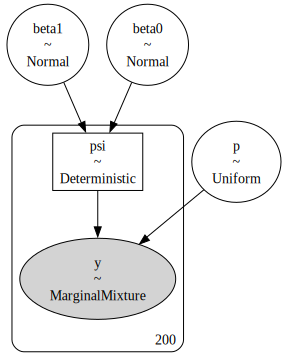

In [8]:
with pm.Model() as psix:

    # occurrence process 
    # priors 
    beta0 = pm.Normal("beta0", mu=0, sigma=2)
    beta1 = pm.Normal("beta1", mu=0, sigma=2)
    
    # linear model
    mu = beta0 + beta1 * x
    psi = pm.Deterministic("psi", pm.math.invlogit(mu))

    # detection process
    # prior
    p = pm.Uniform('p', 0, 1)

    # likelihood for the summarized data
    pm.ZeroInflatedBinomial('y', p=p, psi=psi, n=visit_count, 
                            observed=y_summarized)

pm.model_to_graphviz(psix)

In [9]:
with psix:
    psix_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


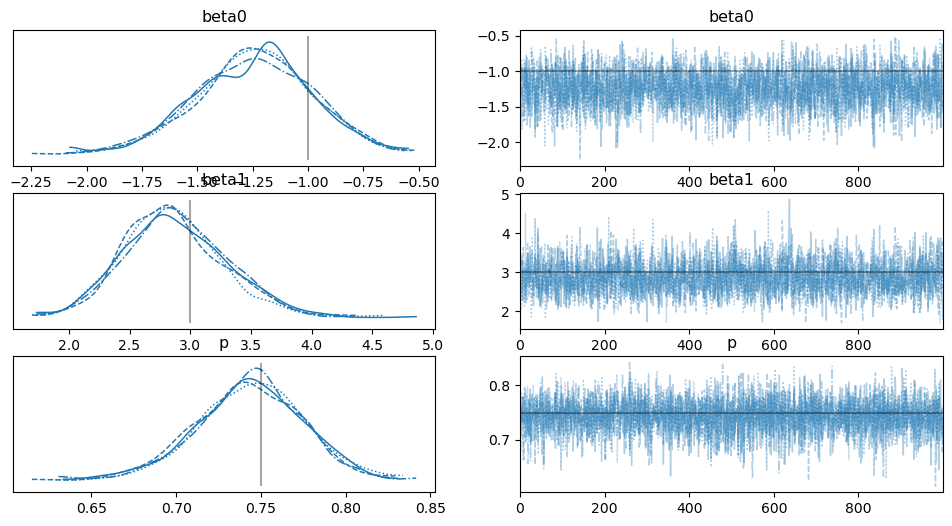

In [10]:
az.plot_trace(
    psix_idata,
    var_names=['beta0', 'beta1', 'p'],
    lines=[("beta0", {}, [beta0_true]), ("beta1", {}, [beta1_true]), 
           ('p', {}, [p_true])]
);

In [11]:
az.summary(psix_idata, var_names=['beta0', 'beta1', 'p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-1.244,0.261,-1.712,-0.736,0.005,0.004,2654.0,2642.0,1.0
beta1,2.870,0.416,2.114,3.657,0.008,0.006,2535.0,2653.0,1.0
p,0.744,0.031,0.687,0.806,0.000,0.000,4961.0,2879.0,1.0


## Adding visit covariates

Finally, I add in visit-level covariate $w_{j,k}$ that affects detection.

In [12]:
## ecological model

# true parameter values
beta0_true = -1
beta1_true = 3

# covariates 
x = scale(rng.uniform(size=site_count))

# linear model
mu_true = beta0_true + beta1_true * x
psi_true = invlogit(mu_true)

# simulate occurrence state
z_true = rng.binomial(1, psi_true)

# true parameter values
alpha0_true = 1
alpha1_true = -3

# covariates
w = rng.uniform(size=site_count * visit_count).reshape(site_count, visit_count)
w = scale(w)

# linear model
nu_true = alpha0_true + alpha1_true * w
p_true = invlogit(nu_true)

# simulate detection
y = sim_y(p_true, z_true, site_count, visit_count)

y[:5]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       [1, 1, 0],
       [0, 0, 0]])

Our PyMC code will need to be a little uglier now. I could write the model in terms of the latent occurrence state $z_j.$ The NUTS sampler, however, does not jive with discrete latent states. As such, PyMC will assign it to a binary Gibbs sampler by default, which works, albeit painfully slowly.

Since I am impatient, I instead use the [marginalized version of the model](https://mbjoseph.github.io/posts/2020-04-28-a-step-by-step-guide-to-marginalizing-over-discrete-parameters-for-ecologists-using-stan/), that is, a model that does not include the discrete latent states. To do this in PyMC, I use the `CustomDist` class. This requires, first, defining the log probability of the distribution, `logp`, given the data and it's parameters. We can write `logp` using the likelihood of the occupancy model, 
$$
P(\mathbf{y}_j)= 
\begin{cases}
    P(\mathbf{y}_j | z_j = 1)\; \psi_j \; + \; (1 - \psi_j),   & \text{if } \mathbf{y}_j = \mathbf{0}\\
    P(\mathbf{y}_j | z_j = 1)\; \psi_j,  & \text{otherwise}
\end{cases}
$$
where $P(\mathbf{y}_j | z_j = 1) = \prod_j p_{j,k}^{y_{j,k}} (1-p_{j,k})^{(1-y_{j,k})}$ [@royle2008]. To do this in PyMC, I rely on the `pm.math.switch` function, which is similar to `ifelse()` in R or `np.where()`.

In [13]:
# likelihood for y data
def logp(x, p, psi):
    '''Computes the log-likelihood for an occupancy model

    Args: 
        x: (site_count x visit_count) array with binary detection data
        p: (site_count x visit_count) array of probabilities
        p: site_count vector of probabilities
    '''
    
    bern = (p ** x) * ((1 - p) ** (1 - x))
    bern_prod = pm.math.prod(bern, axis=1)
    
    res = pm.math.switch(
        x.sum(axis=1) > 0,
        bern_prod * psi,
        bern_prod * psi + (1 - psi)
    )
    
    return pm.math.log(res)

Then, I simply provide this function as an argument to the `CustomDist` class in our PyMC model.

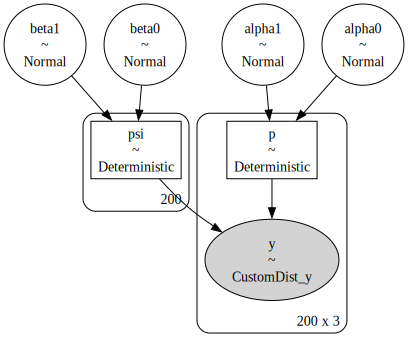

In [14]:
with pm.Model() as marginal:

    # occurrence process 
    # priors 
    beta0 = pm.Normal("beta0", mu=0, sigma=2)
    beta1 = pm.Normal("beta1", mu=0, sigma=2)
    
    # linear model
    mu = beta0 + beta1 * x
    psi = pm.Deterministic("psi", pm.math.invlogit(mu))

    # detection process
    # priors
    alpha0 = pm.Normal('alpha0', mu=0, sigma=2)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=2)

    # linear model
    nu = alpha0 + alpha1 * w
    p = pm.Deterministic('p', pm.math.invlogit(nu))

    # likelihood
    pm.CustomDist(
        'y',
        p,
        psi,
        logp=logp,
        observed=y,
    )

pm.model_to_graphviz(marginal)

In [15]:
with marginal:
    marginal_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, alpha0, alpha1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


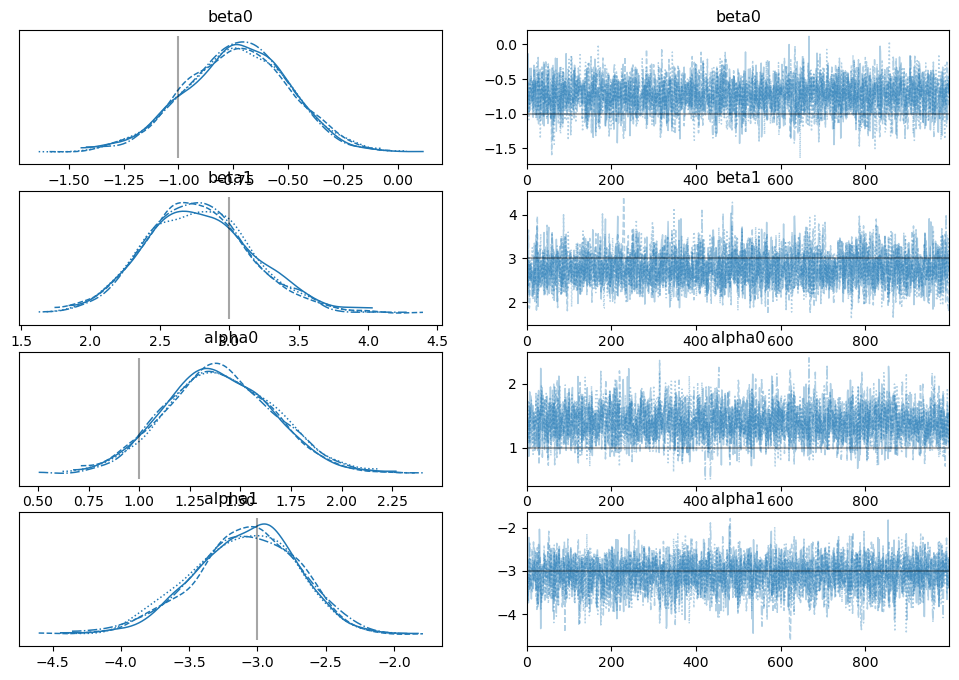

In [16]:
az.plot_trace(
    marginal_idata,
    var_names=['beta0', 'beta1', 'alpha0', 'alpha1'],
    lines=[("beta0", {}, [beta0_true]), ("beta1", {}, [beta1_true]), 
           ('alpha0', {}, [alpha0_true]), ('alpha1', {}, [alpha1_true])]
);

In [17]:
az.summary(marginal_idata, var_names=['beta0', 'beta1', 'alpha0', 'alpha1'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.736,0.237,-1.178,-0.294,0.004,0.003,3495.0,3118.0,1.0
beta1,2.779,0.384,2.123,3.554,0.007,0.005,3245.0,3047.0,1.0
alpha0,1.399,0.266,0.910,1.898,0.005,0.003,3077.0,2885.0,1.0
alpha1,-3.095,0.383,-3.852,-2.443,0.007,0.005,3111.0,2568.0,1.0


# Real data example

Finally, I demonstrate the model using a real data example. These data come from @henden2013, and were used as a demonstration in @hooten2019, Chapter 23. They represent detection/non-detection data of Willow Warblers from Finnmark, Norway. The $J=27$ sites were sampled $K=3$ times. Replicating the analysis in Box 23.7 in @hooten2019, I use two covariates for site: site area and willow tree height. Further, I use two covariates for visit: an indicator for the visit and willow tree height. 

In [18]:
# read in the data
data = pd.read_csv('PlosOne-DataFinnmark.csv')

# subset the data to select willow warbler
is_warbler = data.Species == "Willow Warbler"
Y = data.loc[is_warbler, ['Y05.1', 'Y05.2', 'Y05.3']].to_numpy()
n, J = Y.shape

# generate site covariate matrix
site_intercept = np.ones(n)
pland = scale(data.loc[is_warbler, 'Pland']).to_numpy()
wheight = scale(data.loc[is_warbler, 'wheight']).to_numpy()

X = np.c_[site_intercept, pland, wheight]

# generate visit covariate array
visit_int = np.ones_like(Y)
visit_wheight = np.repeat(wheight, repeats=J).reshape(n, J)

# indicates which visit this is [0, 1, 2, 0, ...]
_, visit_indicator = np.indices(Y.shape)
visit_indicator = scale(visit_indicator)

W = np.stack((visit_int, visit_indicator, visit_wheight), axis=2)

This example uses an extremely handy feature of PyMC: coordinates. This allows us to specify a prior for each $\alpha$ and $\beta$ value in one line of code, using the `dims` argument in our prior distribution. The length of vector is implied by length of the list in `coords`.

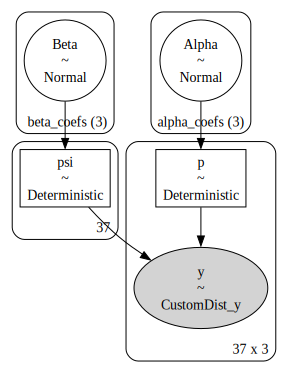

In [19]:
coords = {"beta_coefs": ["Intercept", "Pland", 'Wheight'],
          "alpha_coefs": ["Intercept", "Visit", 'Wheight']}

with pm.Model(coords=coords) as warbler:

    # occurrence process priors 
    Beta = pm.Normal("Beta", mu=0, sigma=2, dims="beta_coefs")
    
    # linear model
    mu = pm.math.dot(X, Beta)
    psi = pm.Deterministic("psi", pm.math.invlogit(mu))

    # detection process priors
    Alpha = pm.Normal('Alpha', mu=0, sigma=2, dims='alpha_coefs')

    # linear model
    nu = pm.math.dot(W, Alpha)
    p = pm.Deterministic('p', pm.math.invlogit(nu))

    # likelihood
    pm.CustomDist(
        'y',
        p,
        psi,
        logp=logp,
        observed=Y,
    )

pm.model_to_graphviz(warbler)

Now the dimensionality of the prior distributions is clear, with (3) different priors specified for each random variable in the vectors $\alpha$ and $\beta$.

In [20]:
with warbler:
    warbler_idata = pm.sample(4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta, Alpha]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 6 seconds.


I upped the number of draw iterations to 4,000 per chain, 16,000 total, since this dataset includes real-world messiness. Nevertheless, sampling the posterior took only 6 seconds!  

In [21]:
az.summary(warbler_idata, var_names=['Alpha', 'Beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Alpha[Intercept],-0.013,0.372,-0.699,0.696,0.004,0.003,10624.0,11038.0,1.0
Alpha[Visit],0.467,0.285,-0.046,1.017,0.002,0.002,13952.0,9365.0,1.0
Alpha[Wheight],0.740,0.433,-0.090,1.530,0.004,0.003,10884.0,10542.0,1.0
Beta[Intercept],0.798,0.820,-0.632,2.368,0.009,0.007,9362.0,8362.0,1.0
Beta[Pland],2.251,0.870,0.736,3.908,0.009,0.007,10579.0,9017.0,1.0
Beta[Wheight],0.955,0.686,-0.287,2.314,0.006,0.004,12297.0,10640.0,1.0


I compare the parameter estimates to the ones estimated by @hooten2019, Chapter 23. 

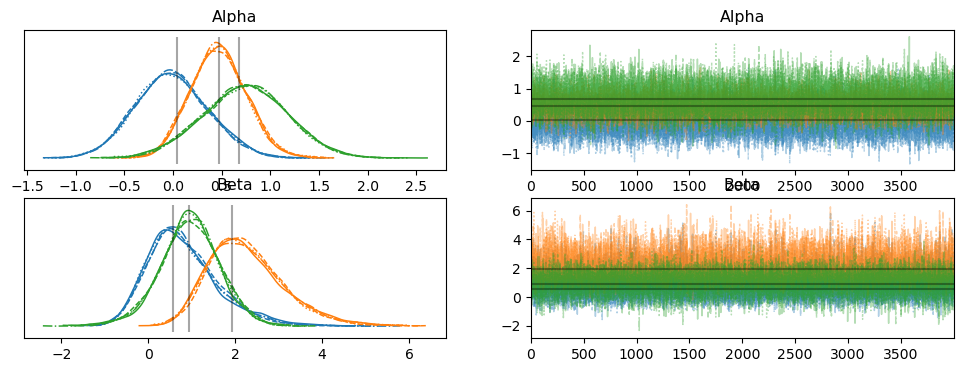

In [22]:
alpha_hat_hooten =  [0.04, 0.47, 0.68]
beta_hat_hooten = [0.56, 1.92, 0.93]

az.plot_trace(
    warbler_idata,
    var_names=['Alpha', 'Beta'],
    lines=[("Alpha", {}, [alpha_hat_hooten]), 
           ("Beta", {}, [beta_hat_hooten])]
);

There is a high level of agreement between the two methods. While their algorithm was designed for teaching and interpretability, it is noteworthy that the PyMC model is 10x faster. 

Arviz also produces forest plots for looking at effect sizes. 

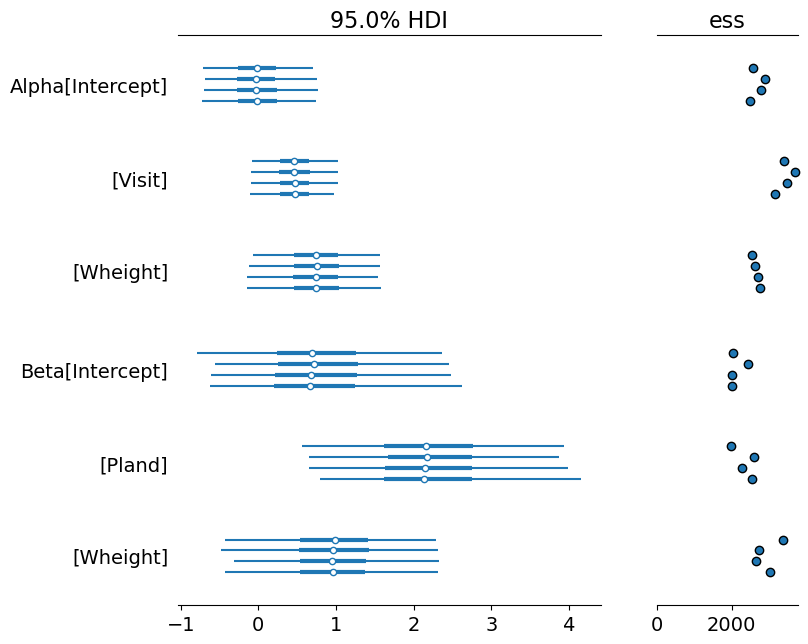

In [23]:
az.plot_forest(warbler_idata, var_names=['Alpha', "Beta"], 
               hdi_prob=0.95, ess=True);

## Model comparison

PyMC also has handy tools for model comparison. I demonstrate these by fitting a model to the warbler data with a constant probability of detection. 

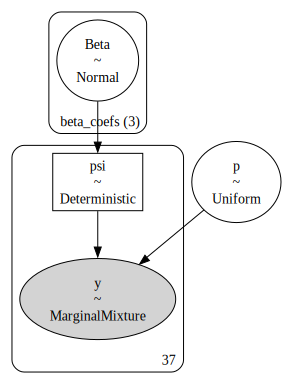

In [24]:
Y_sum = Y.sum(axis=1)

with pm.Model(coords=coords) as warbler_constantp:

    # occurrence process priors 
    Beta = pm.Normal("Beta", mu=0, sigma=2, dims="beta_coefs")
    
    # linear model
    mu = pm.math.dot(X, Beta)
    psi = pm.Deterministic("psi", pm.math.invlogit(mu))

    # detection process priors
    p = pm.Uniform('p', 0, 1)

    # likelihood
    pm.ZeroInflatedBinomial('y', p=p, psi=psi, n=J, observed=Y_sum)

pm.model_to_graphviz(warbler_constantp)

In [25]:
with warbler_constantp:
    warbler_constantp_idata = pm.sample(4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta, p]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 7 seconds.


Next, I caclculate the leave-one-out (loo) cross-validation score for each model [@vehtari2017]. This involves first computing the log likelihood for each model. 

In [26]:
with warbler:
    pm.compute_log_likelihood(warbler_idata)

In [27]:
warbler_loo = az.loo(warbler_idata)

warbler_loo

Computed from 16000 posterior samples and 37 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -54.31     7.36
p_loo        6.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       37  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [28]:
with warbler_constantp:
    pm.compute_log_likelihood(warbler_constantp_idata)

In [29]:
warbler_constantp_loo = az.loo(warbler_constantp_idata)

warbler_constantp_loo

Computed from 16000 posterior samples and 37 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -39.33     5.12
p_loo        3.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       37  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Arviz has handy tools for comparing the results. First, I generate a tabular summary. 

In [30]:
df_comp_loo = az.compare({r"$p(visit,wheight)$": warbler_idata, 
                          r"$p(\cdot)$": warbler_constantp_idata})
df_comp_loo

/Users/philtpatton/miniforge3/envs/mc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/philtpatton/miniforge3/envs/mc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
$p(\cdot)$,0,-39.330588,3.802882,0.0000,1.0,5.124801,0.000000,False,log
"$p(visit,wheight)$",1,-54.306088,6.087527,14.9755,0.0,7.362194,4.185283,False,log


This indicates that the $p(\cdot)$ model is favored over the $p(visit,wheight)$ model. 

Arviz also generates plots for these comparisons. 

/Users/philtpatton/miniforge3/envs/mc/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


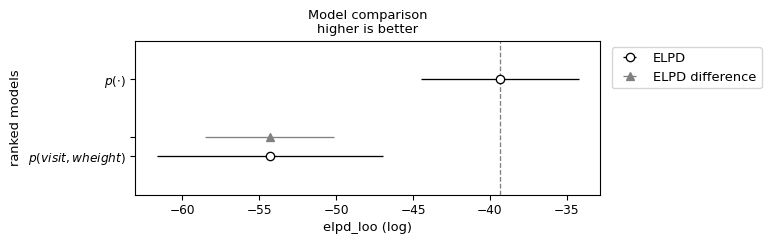

In [31]:
az.plot_compare(df_comp_loo, insample_dev=False);